In [1]:
import pandas as pd
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import regex
from multiprocessing import Pool
from joblib import Parallel, delayed
from tqdm import tqdm
from funcs import *

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\tqdm\std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
tqdm.pandas() # Registering instance of tqdm with pandas so I can check progress on .apply()

In [3]:
style.use('fivethirtyeight')

In [4]:
songs = pd.read_csv('./data/five_genres_500_samp_upd.csv')
songs.drop(columns='Unnamed: 0', inplace=True)

In [5]:
classical_samp = songs[songs['genre'] == 'classical']

In [6]:
rap_samp = songs[songs['genre'] == 'rap']

In [7]:
rap_samp['location'].values[0]

'./scrapes/rap/001500_Stop the Madness feat Gunna.mp3'

In [8]:
x, sr = librosa.load(rap_samp['location'].values[0])

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


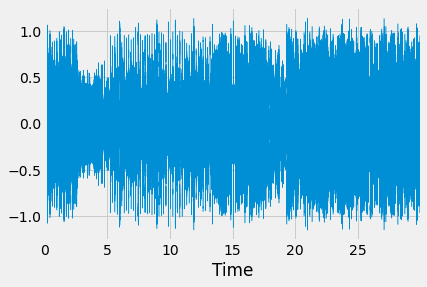

In [9]:
librosa.display.waveplot(x)

In [10]:
hop_length = 512
n_fft = 2048
X = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)

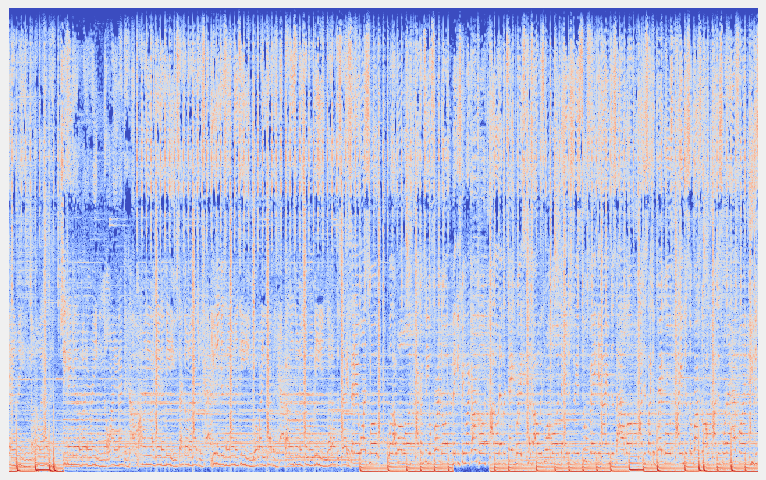

In [11]:
plt.figure(figsize=(12, 8))
S = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(S, sr=sr);

## Calculating Energy and RMSE

**Energy** is the total magnitude of the signal, **RMSE** stands for Root Mean Squared Energy. These are different ways of measuring loudness of a signal and require us to set windows of time.

In [12]:
%%time
x = librosa.load(rap_samp['location'].values[0])

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Wall time: 821 ms


In [13]:
# Creating empty columns to fill
songs['energy_calc'] = np.zeros_like(songs['location'])
songs['rms_calc'] = np.zeros_like(songs['location'])
songs['mfcc_calc'] = np.zeros_like(songs['location'])


In [14]:
for location in tqdm(songs['location']):
    new_cols(songs, location)

100%|██████████| 2500/2500 [34:58<00:00,  1.19it/s]


In [17]:
songs['max_rms'] = songs['rms_calc'].apply(np.max)
songs['std_rms'] = songs['rms_calc'].apply(np.std)
songs['median_rms'] = songs['rms_calc'].apply(np.median)
songs['min_rms'] = songs['rms_calc'].apply(np.min)

In [48]:
songs['mfcc_means'] = songs['mfcc_calc'].progress_apply(lambda x: [x[i].mean() for i in range(len(x))])

100%|██████████| 2500/2500 [00:42<00:00, 59.32it/s]


In [61]:
songs['energy_calc'][0].mean() / songs['energy_calc'][0].max()

0.1154086414320865

In [62]:
songs['energy_mean_norm'] = songs['energy_calc'].progress_apply(lambda x: x.mean() / x.max())

100%|██████████| 2500/2500 [00:00<00:00, 64088.40it/s]


In [78]:
songs.to_csv('./data/five_g_500_samp_add_feats.csv')

In [66]:
songs.groupby('genre').mean()[['max_rms', 'std_rms', 'median_rms', 'min_rms', 'energy_mean_norm']

,max_rms,std_rms,median_rms,min_rms,energy_mean_norm,energy
genre,,,,,,
classical,0.439928,0.065135,0.108902,0.015367,0.107327,0.134257
progressive bluegrass,0.466479,0.065989,0.177579,0.040304,0.186371,0.516847
r&b,0.680158,0.109921,0.217299,0.029345,0.155211,0.578024
rap,0.724525,0.129127,0.271492,0.029314,0.197374,0.608956
rock,0.482532,0.062070,0.199436,0.057674,0.207736,0.725078


In [72]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                2500 non-null   object 
 1   genre             2500 non-null   object 
 2   track_name        2500 non-null   object 
 3   preview_url       2500 non-null   object 
 4   location          2500 non-null   object 
 5   filename          2500 non-null   object 
 6   artist            2500 non-null   object 
 7   artist_uri        2500 non-null   object 
 8   album             2500 non-null   object 
 9   release_date      2500 non-null   object 
 10  danceability      2500 non-null   float64
 11  energy            2500 non-null   float64
 12  key               2500 non-null   int64  
 13  loudness          2500 non-null   float64
 14  mode              2500 non-null   int64  
 15  speechiness       2500 non-null   float64
 16  acousticness      2500 non-null   float64


In [73]:
songs['mfcc_mean'] = songs['mfcc_calc'].progress_apply(lambda x: x.mean())

100%|██████████| 2500/2500 [00:00<00:00, 25767.53it/s]


In [75]:
songs['mfcc_std'] = songs['mfcc_calc'].progress_apply(lambda x: x.std())

100%|██████████| 2500/2500 [00:00<00:00, 15429.45it/s]


In [76]:
songs['mfcc_min'] = songs['mfcc_calc'].progress_apply(lambda x: x.min())
songs['mfcc_max'] = songs['mfcc_calc'].progress_apply(lambda x: x.max())

100%|██████████| 2500/2500 [00:00<00:00, 86189.76it/s]


In [77]:
songs.corr()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,max_rms,std_rms,median_rms,min_rms,energy_mean_norm,mfcc_mean,mfcc_std,mfcc_min,mfcc_max
danceability,1.000000,0.397841,-0.022571,0.576495,-0.113231,0.403826,-0.540508,-0.431801,-0.040796,0.432582,0.068186,0.599101,0.622991,0.448036,-0.121077,0.115538,0.373872,-0.473105,-0.004064,-0.299871
energy,0.397841,1.000000,0.013595,0.832761,-0.043853,0.238507,-0.790210,-0.412995,0.151531,0.505729,0.249497,0.334669,0.199003,0.574703,0.467129,0.485324,0.743471,-0.815363,0.651144,-0.405448
key,-0.022571,0.013595,1.000000,0.004855,-0.110274,-0.019620,0.004680,-0.012992,0.029879,0.080998,0.013978,-0.029317,-0.030477,-0.035232,0.001222,-0.000872,-0.004417,-0.002481,0.011090,-0.011757
loudness,0.576495,0.832761,0.004855,1.000000,-0.072911,0.280453,-0.754393,-0.557656,0.079254,0.455983,0.235692,0.512349,0.398780,0.666273,0.354477,0.464995,0.737457,-0.870011,0.524279,-0.464311
mode,-0.113231,-0.043853,-0.110274,-0.072911,1.000000,-0.157415,0.109485,0.113714,0.035084,0.043290,0.031288,-0.228903,-0.234454,-0.119627,0.045316,0.008553,-0.042463,0.112814,0.044111,0.121229
speechiness,0.403826,0.238507,-0.019620,0.280453,-0.157415,1.000000,-0.324100,-0.257811,-0.024767,0.079043,0.107435,0.489730,0.570863,0.359777,-0.143914,0.115453,0.125948,-0.240343,-0.129197,-0.131542
acousticness,-0.540508,-0.790210,0.004680,-0.754393,0.109485,-0.324100,1.000000,0.525866,-0.066145,-0.332221,-0.195788,-0.495200,-0.396817,-0.609812,-0.311979,-0.411394,-0.728492,0.794337,-0.453947,0.498490
instrumentalness,-0.431801,-0.412995,-0.012992,-0.557656,0.113714,-0.257811,0.525866,1.000000,-0.075483,-0.184565,-0.104654,-0.369492,-0.331104,-0.359000,-0.094955,-0.204410,-0.404449,0.561860,-0.186073,0.463803
liveness,-0.040796,0.151531,0.029879,0.079254,0.035084,-0.024767,-0.066145,-0.075483,1.000000,0.121833,0.044781,-0.062663,-0.076507,0.006347,0.097898,0.058194,0.074446,-0.093685,0.139580,-0.032258
valence,0.432582,0.505729,0.080998,0.455983,0.043290,0.079043,-0.332221,-0.184565,0.121833,1.000000,0.209035,0.116628,0.128409,0.082201,-0.030722,0.068302,0.248421,-0.396694,0.209492,-0.226358


In [ ]:
frames = range(len(energy))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

In [ ]:
plt.figure(figsize=(25, 8))
librosa.display.waveplot(x)
plt.plot(t, rms[0], label='RMS', linewidth=1.5, linestyle='--')
plt.plot(t, energy_norm, label='Energy', linewidth=1.5, linestyle='--')
plt.legend()